In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Config
original_dim = 28 * 28
intermediate_dim1 = 256
intermediate_dim2 = 128
intermediate_dim3 = 64
latent_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(original_dim, intermediate_dim1)
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        self.z_mean = nn.Linear(intermediate_dim3, latent_dim)
        self.z_log_var = nn.Linear(intermediate_dim3, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        z = z_mean + eps * std
        return z_mean, z_log_var, z

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, intermediate_dim3)
        self.fc2 = nn.Linear(intermediate_dim3, intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim1)
        self.fc4 = nn.Linear(intermediate_dim1, original_dim)

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))

# VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_log_var

def vae_loss(x, x_recon, z_mean, z_log_var):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return recon_loss + kl_loss


In [3]:
# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

def flatten_dataset(dataset):
    data = dataset.data.float() / 255.
    data = data.view(-1, 28 * 28)
    return TensorDataset(data)

train_loader = DataLoader(flatten_dataset(train_dataset), batch_size=32, shuffle=True)
test_loader  = DataLoader(flatten_dataset(test_dataset), batch_size=32)

# Model setup
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
for epoch in range(1, 51):
    vae.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_recon, z_mean, z_log_var = vae(x)
        loss = vae_loss(x, x_recon, z_mean, z_log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}')


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.99MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.1MB/s]


Epoch 1, Loss: 281.1088
Epoch 2, Loss: 252.2460
Epoch 3, Loss: 248.9195
Epoch 4, Loss: 247.3175
Epoch 5, Loss: 246.3535
Epoch 6, Loss: 245.6170
Epoch 7, Loss: 245.0729
Epoch 8, Loss: 244.6399
Epoch 9, Loss: 244.2428
Epoch 10, Loss: 243.9869
Epoch 11, Loss: 243.6041
Epoch 12, Loss: 243.4183
Epoch 13, Loss: 243.2162
Epoch 14, Loss: 242.9269
Epoch 15, Loss: 242.8161
Epoch 16, Loss: 242.7353
Epoch 17, Loss: 242.4729
Epoch 18, Loss: 242.4271
Epoch 19, Loss: 242.3023
Epoch 20, Loss: 242.1900
Epoch 21, Loss: 242.0392
Epoch 22, Loss: 241.9962
Epoch 23, Loss: 241.9008
Epoch 24, Loss: 241.7720
Epoch 25, Loss: 241.6878
Epoch 26, Loss: 241.6935
Epoch 27, Loss: 241.6594
Epoch 28, Loss: 241.5165
Epoch 29, Loss: 241.3963
Epoch 30, Loss: 241.3545
Epoch 31, Loss: 241.4226
Epoch 32, Loss: 241.2038
Epoch 33, Loss: 241.2090
Epoch 34, Loss: 241.1314
Epoch 35, Loss: 241.2089
Epoch 36, Loss: 241.0306
Epoch 37, Loss: 241.0591
Epoch 38, Loss: 240.9740
Epoch 39, Loss: 240.9479
Epoch 40, Loss: 240.8962
Epoch 41,

In [4]:
vae.eval()
with torch.no_grad():
    x_test = test_dataset.data.float().view(-1, 28*28) / 255.
    x_test = x_test.to(device)
    z_mean, _, _ = vae.encoder(x_test)
    x_test_encoded = z_mean.cpu().numpy()


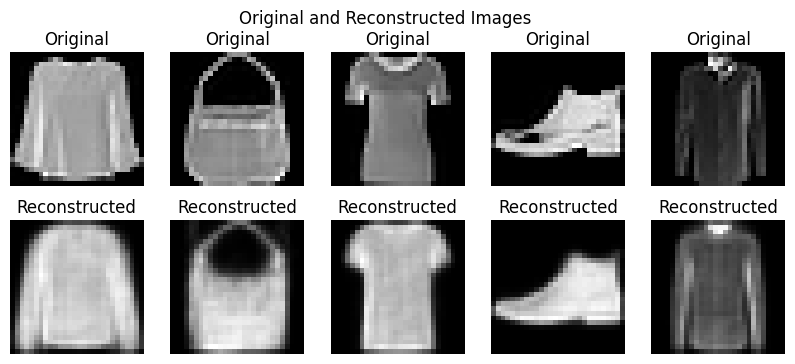

In [6]:
# Function to plot images
def plot_images(original, reconstructed, num_images, title):
    plt.figure(figsize=(num_images * 2, 4))
    for i in range(num_images):
        # Plot original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Plot reconstructed images
        ax = plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Select 5 random images from the test set
num_images = 5
random_indices = np.random.choice(len(x_test), num_images, replace=False)
x_test_sample = x_test[random_indices]

# Use the trained VAE to reconstruct the selected images
with torch.no_grad():
    reconstructed_images,_,_ = vae(x_test_sample)

# Plot the original and reconstructed images
plot_images(x_test_sample.cpu(), reconstructed_images.cpu(), num_images, 'Original and Reconstructed Images')

In [7]:
reconstructed_images.shape

torch.Size([5, 784])

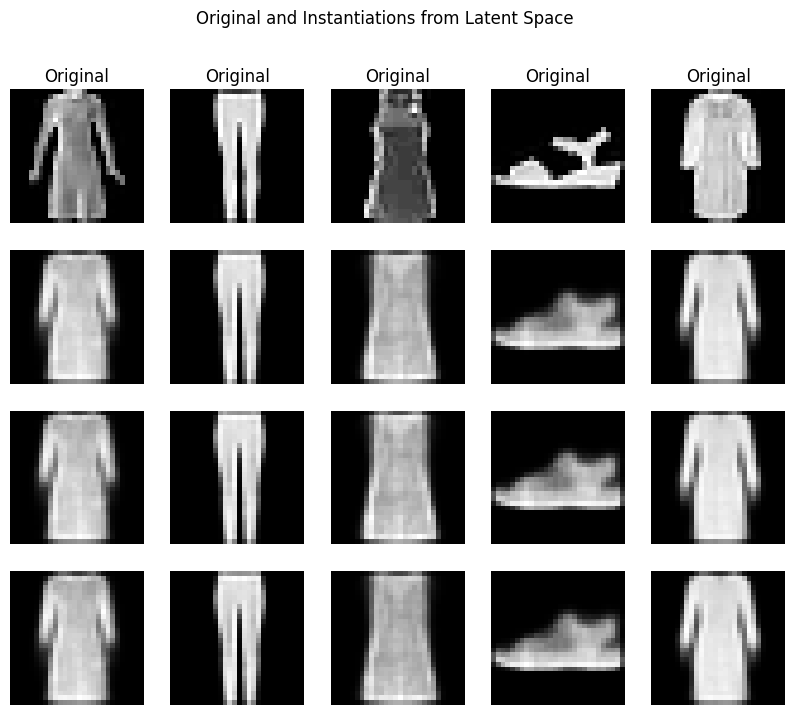

In [11]:
# Function to plot images
def plot_images_grid(original, instantiations, num_images, num_rows=4):
    plt.figure(figsize=(num_images * 2, num_rows * 2))
    for i in range(num_images):
        # Plot original images
        ax = plt.subplot(num_rows, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Plot instantiations
        for j in range(1, num_rows):
            ax = plt.subplot(num_rows, num_images, j * num_images + i + 1)
            plt.imshow(instantiations[j - 1][i].reshape(28, 28), cmap='gray')
            if i == 0:
                ax.set_ylabel(f'Instance {j}', rotation=0, labelpad=30, va='center')
            plt.axis('off')
    plt.suptitle('Original and Instantiations from Latent Space')
    plt.show()

with torch.no_grad():
    # Select 5 random images from the test set
    num_images = 5
    random_indices = np.random.choice(len(x_test), num_images, replace=False)
    x_test_sample = x_test[random_indices]

    # Encode the selected images to get their latent representations
    z_mean, z_log_sigma, _ = vae.encoder(x_test_sample)

    # Generate multiple instantiations from the latent representations
    num_instantiations = 3
    instantiations = []
    for _ in range(num_instantiations):
        sampled_images = []
        for i in range(num_images):
            epsilon = torch.randn((1, latent_dim), device=z_mean.device)
            z_sample = z_mean[i] + torch.exp(z_log_sigma[i]) * epsilon
            generated_image = vae.decoder(z_sample.float())
            sampled_images.append(generated_image.cpu().numpy()) 
        instantiations.append(np.array(sampled_images).squeeze())

    # Plot the original and instantiations in a 4x5 grid
    plot_images_grid(x_test_sample.cpu(), instantiations, num_images)


#VAE - CNN

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]


In [8]:
# Dimensão latente
latent_dim = 16

# Encoder CNN
class EncoderCNN(nn.Module):
    def __init__(self, latent_dim):
        super(EncoderCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1) 
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128*7*7, latent_dim)
        self.fc_logvar = nn.Linear(128*7*7, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        z_mean = self.fc_mu(x)
        z_logvar = self.fc_logvar(x)
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        z = z_mean + eps * std
        return z_mean, z_logvar, z

# Decoder CNN
class DecoderCNN(nn.Module):
    def __init__(self, latent_dim):
        super(DecoderCNN, self).__init__()
        self.fc = nn.Linear(latent_dim, 128*7*7)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1)  
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)   
        self.deconv3 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 128, 7, 7)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

# VAE com CNN
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_CNN, self).__init__()
        self.encoder = EncoderCNN(latent_dim)
        self.decoder = DecoderCNN(latent_dim)

    def forward(self, x):
        z_mean, z_logvar, z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_logvar


In [9]:
def vae_loss(x, x_recon, z_mean, z_logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + kl_loss

def train_vae(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_recon, z_mean, z_logvar = model(x)
            loss = vae_loss(x, x_recon, z_mean, z_logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset):.4f}')


In [10]:
vae_cnn = VAE_CNN(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_cnn.parameters(), lr=1e-3)

train_vae(vae_cnn, train_loader, optimizer, epochs=50)


Epoch 1, Loss: 265.6189
Epoch 2, Loss: 245.6869
Epoch 3, Loss: 242.8209
Epoch 4, Loss: 241.3219
Epoch 5, Loss: 240.2715
Epoch 6, Loss: 239.5120
Epoch 7, Loss: 238.9498
Epoch 8, Loss: 238.4779
Epoch 9, Loss: 238.0453
Epoch 10, Loss: 237.7060
Epoch 11, Loss: 237.4214
Epoch 12, Loss: 237.1774
Epoch 13, Loss: 236.9679
Epoch 14, Loss: 236.7727
Epoch 15, Loss: 236.5233
Epoch 16, Loss: 236.3926
Epoch 17, Loss: 236.2487
Epoch 18, Loss: 236.1211
Epoch 19, Loss: 236.0312
Epoch 20, Loss: 235.8521
Epoch 21, Loss: 235.7802
Epoch 22, Loss: 235.7000
Epoch 23, Loss: 235.5761
Epoch 24, Loss: 235.5177
Epoch 25, Loss: 235.3815
Epoch 26, Loss: 235.3504
Epoch 27, Loss: 235.2757
Epoch 28, Loss: 235.1891
Epoch 29, Loss: 235.1032
Epoch 30, Loss: 235.0799
Epoch 31, Loss: 234.9751
Epoch 32, Loss: 234.9309
Epoch 33, Loss: 234.8760
Epoch 34, Loss: 234.8312
Epoch 35, Loss: 234.7693
Epoch 36, Loss: 234.7397
Epoch 37, Loss: 234.6758
Epoch 38, Loss: 234.6323
Epoch 39, Loss: 234.6043
Epoch 40, Loss: 234.5555
Epoch 41,

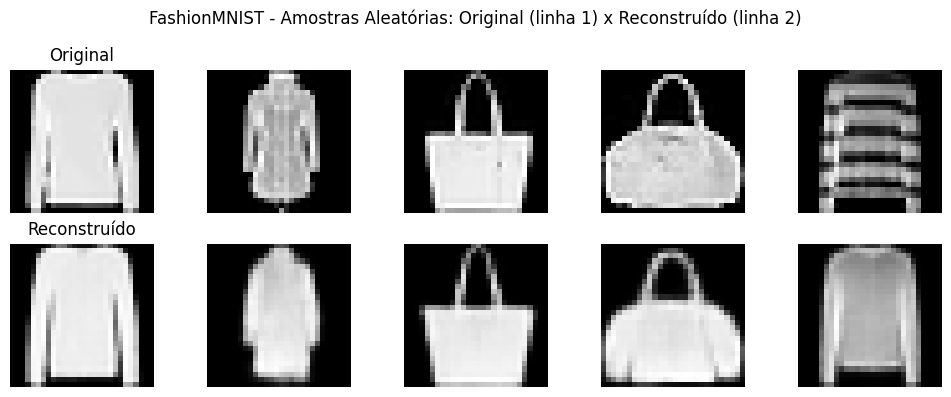

In [14]:
num_test = len(test_dataset)
indices = np.random.choice(num_test, 5, replace=False) 

images = []
for idx in indices:
    img, _ = test_dataset[idx]
    images.append(img.unsqueeze(0)) 

images = torch.cat(images, dim=0).to(device)

vae_cnn.eval()
with torch.no_grad():
    reconstructions, _, _ = vae_cnn(images)

# Para plotar
images = images.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

plt.figure(figsize=(10, 4))
for i in range(5):
    # Originais
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')
    # Reconstruções
    plt.subplot(2, 5, i+6)
    plt.imshow(reconstructions[i][0], cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstruído')
plt.suptitle("FashionMNIST - Amostras Aleatórias: Original (linha 1) x Reconstruído (linha 2)")
plt.tight_layout()
plt.show()
